<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/to_Uniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [307]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import matplotlib.pyplot as plt


%matplotlib inline
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Data shape (1797, 64)


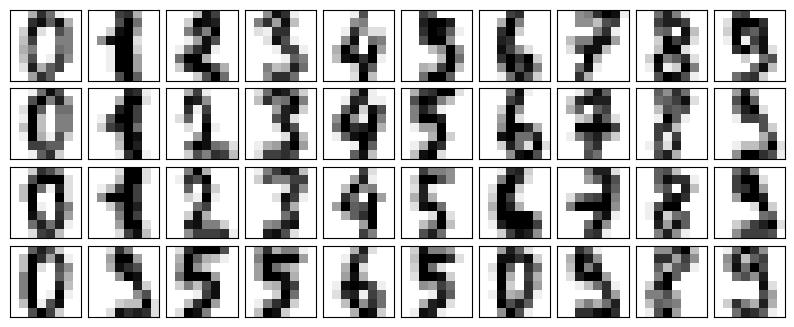

In [308]:
from sklearn.datasets import load_digits


digits = load_digits()
X = digits.data
print('Data shape', X.shape)


def plot_digits(data, w=8):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(w, w),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

plot_digits(digits.data)


In [309]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [310]:
class To_Uniform(torch.nn.Module):

    def __init__(self, input_dim, hidden_layer, output_dim):
        super(To_Uniform, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.output_dim = output_dim

        self.linear1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x

    def criterion(self, y, y_hat):
      return - nn.MSELoss()(y, y_hat)

In [311]:
X = digits.data
X = X.reshape(1797, 64)
X = (X - X.min()) / (X.max()-X.min())

X = Data(torch.from_numpy(X).type(torch.float32))
y = torch.from_numpy(digits.target).type(torch.float32)

In [312]:
model = To_Uniform(64, 256, 24)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [313]:
train_loader = DataLoader(X, batch_size=1797, shuffle=True)

In [314]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        x_ = x.type(torch.float32) + torch.normal(mean=0.0, std=0.000001, size=(1797, 64)).type(torch.float32)
        y_hat = model(x_)

        y = model(x)

        loss = model.criterion(y, y_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  -1.9239341023102874e-11
Epoch :  2   -----------> Loss :  -1.8708775847975367e-11
Epoch :  3   -----------> Loss :  -1.9991487631987326e-11
Epoch :  4   -----------> Loss :  -1.903962404403714e-11
Epoch :  5   -----------> Loss :  -1.8166837825739357e-11
Epoch :  6   -----------> Loss :  -1.9131515816006583e-11
Epoch :  7   -----------> Loss :  -1.9243672627622388e-11
Epoch :  8   -----------> Loss :  -1.84346340276198e-11
Epoch :  9   -----------> Loss :  -1.9221770009014705e-11
Epoch :  10   -----------> Loss :  -1.8272163296306765e-11
Epoch :  11   -----------> Loss :  -1.8729058234856488e-11
Epoch :  12   -----------> Loss :  -1.846275216044191e-11
Epoch :  13   -----------> Loss :  -1.8925319644758076e-11
Epoch :  14   -----------> Loss :  -1.974215582678518e-11
Epoch :  15   -----------> Loss :  -1.9487867916612167e-11
Epoch :  16   -----------> Loss :  -1.9454210811731265e-11
Epoch :  17   -----------> Loss :  -1.951375519504417e-11
Epoch :  18 

In [315]:
Y = model(x)

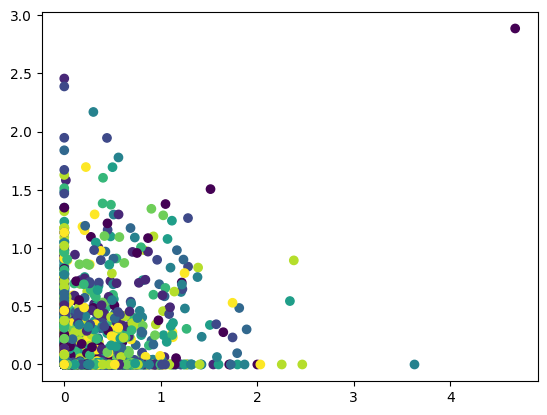

In [316]:
plt.scatter(Y[:,0].detach().numpy(), Y[:,1].detach().numpy(), c=digits.target)
plt.show()

In [317]:
Y.detach().numpy()

array([[0.24494231, 0.        , 0.        , ..., 0.        , 0.5349931 ,
        0.        ],
       [0.        , 0.60538405, 0.        , ..., 0.        , 0.        ,
        0.13889995],
       [0.6158731 , 0.        , 0.10720651, ..., 0.        , 0.        ,
        0.03723755],
       ...,
       [0.        , 0.08310993, 0.        , ..., 0.54062563, 0.20855293,
        0.        ],
       [0.52353317, 0.        , 0.        , ..., 1.5079801 , 0.        ,
        0.33418244],
       [1.4030479 , 0.        , 0.        , ..., 0.65132433, 0.15884337,
        0.33384573]], dtype=float32)